# Libraries preparation:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Dataset loading:

In [2]:
# Import the dataset
df = pd.read_csv('LOG_AAPL_QUARTERLY_FINANCIALDATA.csv')

print(df.head())

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

  Quarter        Date  LOG_CLOSE  LOG_GROSS    LOG_NET  LOG_ASSETS  \
0  2005Q3   9/24/2005   2.281033  11.014940  10.633468   12.061302   
1  2005Q4  12/31/2005   2.409933  11.194237  10.752048   12.151707   
2  2006Q1    4/1/2006   2.350248  11.112940  10.612784   12.143358   
3  2006Q2    7/1/2006   2.311754  11.122216  10.673942   12.179379   
4  2006Q3   9/30/2006   2.439333  11.149835  10.733999   12.235655   

   LOG_LIABILITIES    LOG_VOL  LOG_EPS  
0        11.611511  11.058618  0.30103  
1        11.763503  11.208293  0.30103  
2        11.718419  11.358179  0.30103  
3        11.762228  11.282927  0.30103  
4        11.858597  11.278244  0.30103  


In [3]:
# Define the features (X) and target (y)
# Independent variables:
X = df[['LOG_GROSS', 'LOG_LIABILITIES', 'LOG_ASSETS']]
# Dependent variable:
y = df['LOG_CLOSE']

# Add a constant to the features (intercept term)
X = sm.add_constant(X)

# Create and fit the model
model = sm.OLS(y, X).fit()

# Split the data into training and testing sets
    # 20% of the data (16 last quarter: 26/09/2020-29/06/2024) will be used for testing set - the remaining 80% will be used for training test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

test_indices = X_test.index
print("Test set indices:", test_indices)

Test set indices: DatetimeIndex(['2020-09-26', '2020-12-26', '2021-03-27', '2021-06-26',
               '2021-09-25', '2021-12-25', '2022-03-26', '2022-06-25',
               '2022-09-24', '2022-12-31', '2023-04-01', '2023-07-01',
               '2023-09-30', '2023-12-30', '2024-03-30', '2024-06-29'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [5]:
# Get the summary table
summary = model.summary2().tables[1]

# Format the p-values to show more decimal places
summary['P>|t|'] = summary['P>|t|'].apply(lambda x: '{:.2e}'.format(x))

# Print the summary of the regression results
print(model.summary())

#print(summary)

                            OLS Regression Results                            
Dep. Variable:              LOG_CLOSE   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     433.8
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           5.33e-46
Time:                        17:56:36   Log-Likelihood:                 46.253
No. Observations:                  76   AIC:                            -84.51
Df Residuals:                      72   BIC:                            -75.18
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.4781      0.645     

# LINEAR REGRESSION:

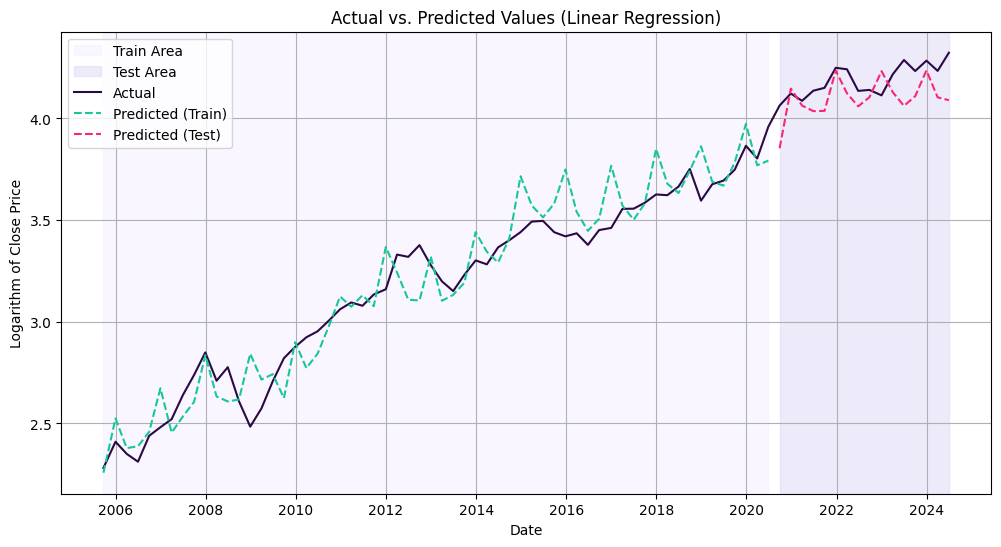

In [6]:
# Make predictions
predictions = model.predict(X)

y = pd.concat([y_train, y_test])

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

plt.figure(figsize=(12, 6))

# Highlight the train and test areas 
plt.axvspan(df.index[0], df.index[len(y_train)-1], color='#F4EEFF', alpha=0.5, label='Train Area') 
plt.axvspan(df.index[len(y_train)], df.index[-1], color='#DCD6F7', alpha=0.5, label='Test Area')

plt.plot(y.index, y, label='Actual', color='#2A0944')
plt.plot(y_train.index, train_predictions, label='Predicted (Train)', color='#16C79A', linestyle='--')
plt.plot(y_test.index, test_predictions, label='Predicted (Test)', color='#FB2576', linestyle='--')

plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Logarithm of Close Price')
plt.legend()
plt.grid()
plt.show()

Forecasting model accuracy measurement:


In [8]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, test_predictions)
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 0.125327994041534
Mean Absolute Error (MAE): 0.1051852431567149


# LASSO REGRESSION:

Perform Grid Search to determine the alpha value:

In [9]:
# Define the parameter grid
param_grid = {'alpha': np.logspace(-4, 4, 50)}

# Create the Lasso model
lasso = Lasso()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best alpha: 0.009102981779915217


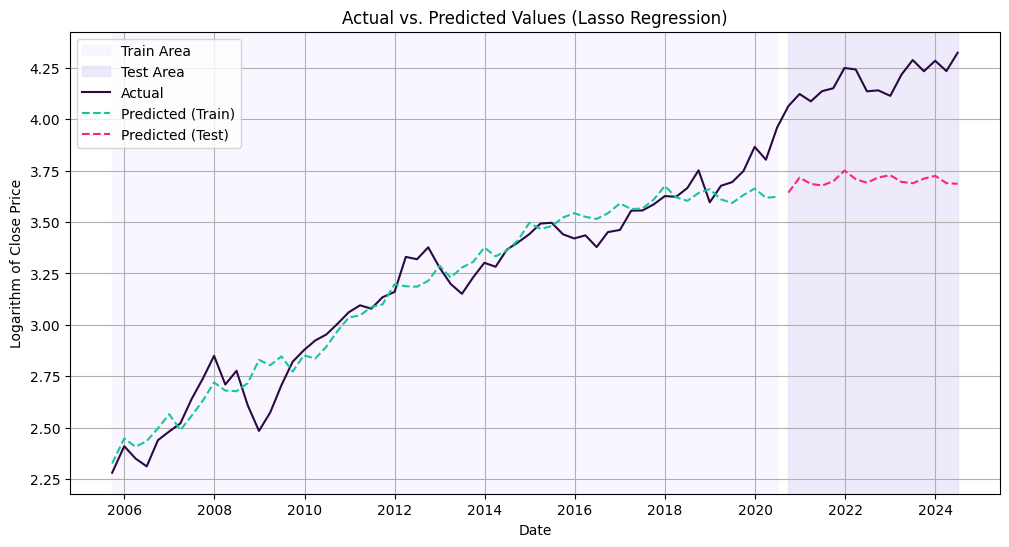

In [10]:
# Initialize Lasso regression model with alpha (regularization parameter)
lasso_model = Lasso(alpha=best_alpha, random_state=42)
# Fit the Lasso model on the training data
lasso_model.fit(X_train, y_train)

# Make predictions using the Lasso model
predictions_lasso_train = lasso_model.predict(X_train)
predictions_lasso_test = lasso_model.predict(X_test)

# Plot the actual vs. predicted values for Lasso Regression
y_actual = pd.concat([y_train, y_test])
plt.figure(figsize=(12, 6))
# Highlight the train and test areas 
plt.axvspan(df.index[0], df.index[len(y_train)-1], color='#F4EEFF', alpha=0.5, label='Train Area') 
plt.axvspan(df.index[len(y_train)], df.index[-1], color='#DCD6F7', alpha=0.5, label='Test Area')
plt.plot(df.index, y_actual, label='Actual', color='#2A0944')
plt.plot(df.index[:len(y_train)], predictions_lasso_train, label='Predicted (Train)', color='#16C79A', linestyle='--')
plt.plot(df.index[len(y_train):], predictions_lasso_test, label='Predicted (Test)', color='#FB2576', linestyle='--')
plt.title('Actual vs. Predicted Values (Lasso Regression)')
plt.xlabel('Date')
plt.ylabel('Logarithm of Close Price')
plt.legend()
plt.grid()
plt.show()

Forecasting model accuracy measurement:

In [11]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions_lasso_test))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, predictions_lasso_test)
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 0.4936708229444945
Mean Absolute Error (MAE): 0.4882761533465008


# ELASTIC NET:

In [12]:
# Define the parameter grid 
param_grid = {
    'alpha': np.logspace(-4, 4, 50),
    'l1_ratio': np.linspace(0, 1, 10)
}
# Create the Elastic Net model
elastic_net = ElasticNet()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters: {'alpha': np.float64(0.040949150623804234), 'l1_ratio': np.float64(0.0)}


In [13]:
# Create and fit the Elastic Net model with the best parameters
elastic_net_best = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'])
elastic_net_best.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = elastic_net_best.predict(X_train)
y_test_pred = elastic_net_best.predict(X_test)

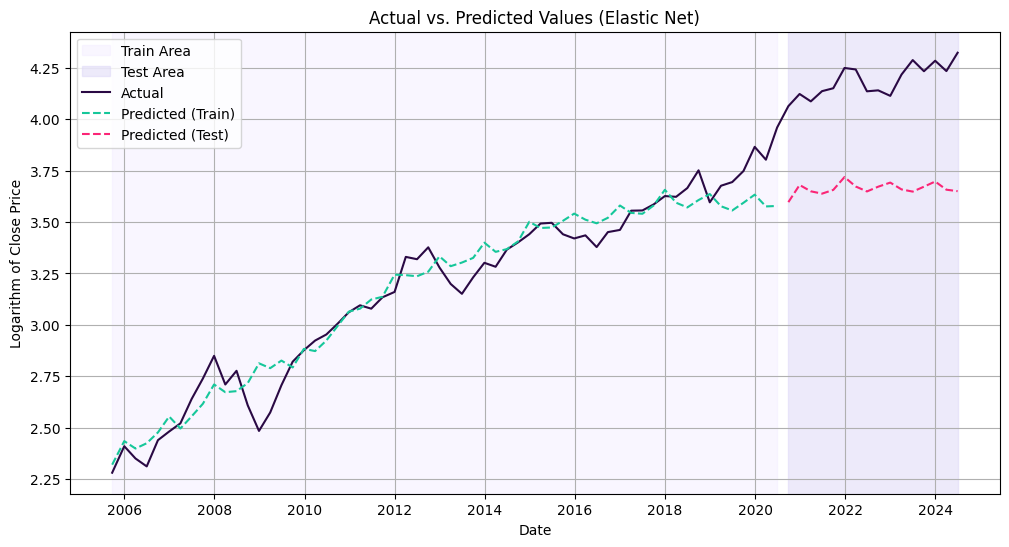

In [14]:
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
# Highlight the train and test areas 
plt.axvspan(df.index[0], df.index[len(y_train)-1], color='#F4EEFF', alpha=0.5, label='Train Area') 
plt.axvspan(df.index[len(y_train)], df.index[-1], color='#DCD6F7', alpha=0.5, label='Test Area')

plt.plot(y.index, y, label='Actual', color='#2A0944')
plt.plot(y_train.index, y_train_pred, label='Predicted (Train)', color='#16C79A', linestyle='--')
plt.plot(y_test.index, y_test_pred, label='Predicted (Test)', color='#FB2576', linestyle='--')

plt.title('Actual vs. Predicted Values (Elastic Net)')
plt.xlabel('Date')
plt.ylabel('Logarithm of Close Price')
plt.legend()
plt.grid(True)
plt.show()

Forecasting model accuracy measurement:

In [15]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Mean Absolute Error (MAE): {mae}')

Root Mean Squared Error (RMSE): 0.5306263536569767
Mean Absolute Error (MAE): 0.5258387476118811
